In [50]:
from netCDF4 import Dataset as open_ncfile
import matplotlib.pyplot as plt
import numpy as np
import pandas

In [51]:
path = '/home/jcharrel/Documents/M2_Internship_LMD/data/Data_for_histograms_JB/'

In [99]:
def process_obs(cc, condition) :
    foceobs = pandas.read_csv(path+'land_ocean_mask2_2d_v2.asc',sep=';')
    foceobs = foceobs.values

    nc = open_ncfile(path+cc+'calipso_obs4cmip5_CALIOP_L3_CALIPSO-GOCCP-v2.1_2007-2008.nc', 'r')
    lat = nc.variables['lat'][:]
    lon = nc.variables['lon'][:]
    time = nc.variables['time'][:]
    cc = nc.variables[cc+'calipso'][:]
    
    if condition == 'ocean' :
        foceobs[foceobs == 1.] = np.nan
        foceobs[foceobs == 0.] = 1.
    elif condition == 'continent' : 
        foceobs[foceobs == 0.] = np.nan
        foceobs[foceobs == 1.] = 1.
    else :
        print('error')
    cc[cc < 1E-2] = np.nan
    cc[cc > 1.] = np.nan
    
    # Shiftgrid
    longi_shift = lon + 180.0
    longi_shift[longi_shift > 360] -= 360
    
    ccobs = np.zeros(cc.shape)
    for i in range(len(lon)):
        idx = np.where(longi_shift[i] == lon)[0][0]
        ccobs[:,:, i] = cc[:, :, idx]
    
    ccobsf = ccobs[0,:,:]*foceobs
    for itime in range(1,ccobs.shape[0]):
        cctmp = ccobs[itime,:,:]*foceobs
        ccobsf = np.dstack((cctmp,ccobsf))
        #print(ccobsf.shape)
    
    ccobsf = np.stack(np.stack(ccobsf, axis=2),axis=2)
    
    ccobsflat=np.ndarray.flatten(ccobsf[:,:15,:]) #sous 60°S
    ccobsflat=ccobsflat[~np.isnan(ccobsflat)]
    return ccobsflat

In [100]:
ccobsflat_h_cont = process_obs('clh','continent')
ccobsflat_m_cont = process_obs('clm','continent')
ccobsflat_l_cont = process_obs('cll','continent')

ccobsflat_h_ocean = process_obs('clh','ocean')
ccobsflat_m_ocean = process_obs('clm','ocean')
ccobsflat_l_ocean = process_obs('cll','ocean')

In [63]:
def process_lmdz(cc, condition) :
    nc = open_ncfile(path+'LmdzOr6Actrl_SE_1980_1999_1M_histmth_fract_oce.nc')
    foce = np.nanmean(nc.variables['fract_oce'][:],axis=0)
    
    nc = open_ncfile(path+'LmdzOr6Actrl_19900101_19991230_1D_'+cc+'calipso.nc')
    lat = nc.variables['lat'][:]
    lon = nc.variables['lon'][:]
    time = nc.variables['time_counter'][:]
    cc = nc.variables[cc+'calipso'][:]

    if condition == 'ocean' :
        foce[foce != 1] = np.nan
    elif condition == 'continent' : 
        foce[foce == 1] = np.nan
    else :
        print('error')
        
    cc[cc > 1.] = np.nan
    cc[cc < 1E-2] = np.nan
    
    cc6A = cc[0,:,:]*foce
    for itime in range(1,ntgcm):
        cctmp = cc[itime,:,:]*foce
        cc6A = np.dstack((cctmp,cc6A))
    
    cc6A = np.stack(np.stack(cc6A, axis=2),axis=2)
    cc6Aflat=np.ndarray.flatten(cc6A[:,120:,:]) # sous 60°S
    cc6Aflat=cc6Aflat[~np.isnan(cc6Aflat)]
    return cc6Aflat

In [57]:
ntgcm=3600
cc6Aflat_h_cont = process_lmdz('clh','continent')

In [64]:
cc6Aflat_m_cont = process_lmdz('clm','continent')
cc6Aflat_l_cont = process_lmdz('cll','continent')

cc6Aflat_h_ocean = process_lmdz('clh','ocean')
cc6Aflat_m_ocean = process_lmdz('clm','ocean')
cc6Aflat_l_ocean = process_lmdz('cll','ocean')

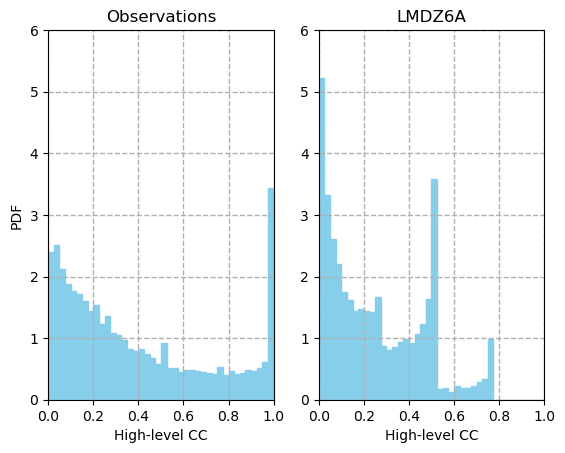

In [58]:
fig, ax = plt.subplots(1,2)

ax[0].hist(ccobsflat_m_cont, range = (0, 1), bins = 40, color = 'skyblue',
            edgecolor = 'skyblue', density=True)
ax[0].grid(linestyle='--', linewidth=1)

ax[1].hist(cc6Aflat_m_cont, range = (0, 1), bins = 40, color = 'skyblue',
            edgecolor = 'skyblue', density=True)
ax[1].grid(linestyle='--', linewidth=1)

ax[0].set_ylabel('PDF')
ax[0].set_title('Observations')
ax[1].set_title('LMDZ6A')
for ax in ax.flat:
    ax.set_xlabel(r"High-level CC")
    ax.set_xlim(xmin=0,xmax=1)
    ax.set_ylim(ymin=0,ymax=6)
    ax.set_xticks(np.arange(0, 101, 20)/1E2)

path_fig = '/home/jcharrel/Documents/M2_Internship_LMD/figures/Histograms_JB/'
#plt.savefig(path_fig+'histo_clh_obs_lmdz6a_under30lat_continent.png',dpi=300)

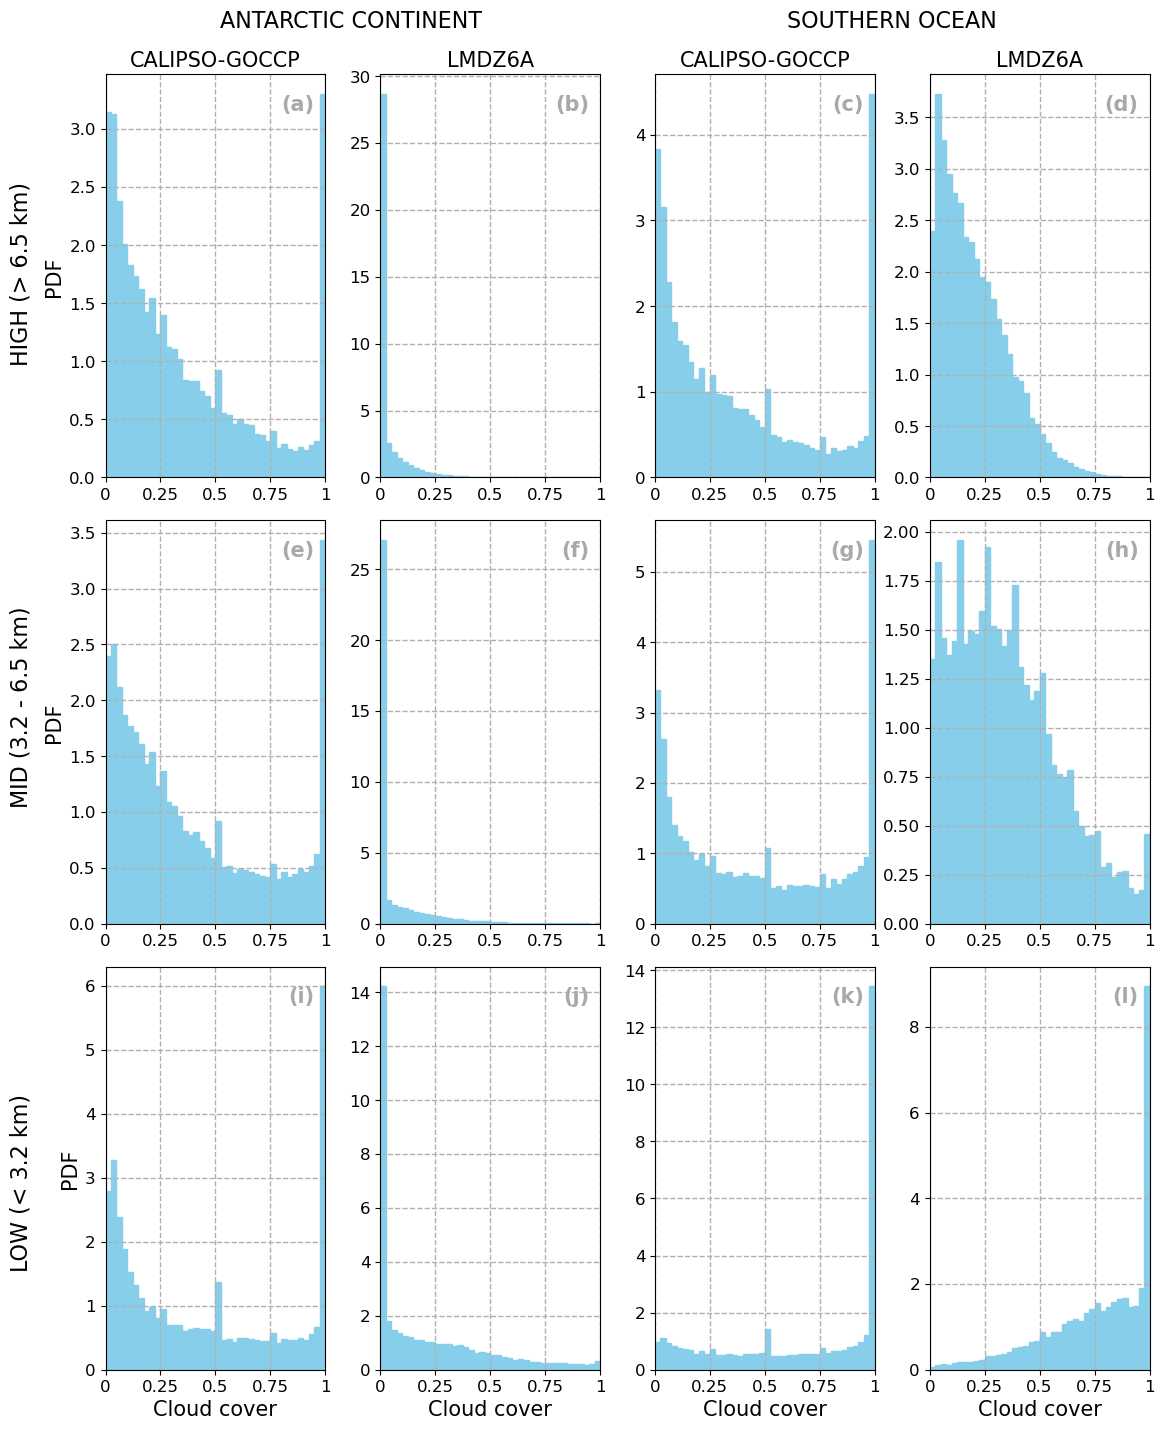

In [134]:
fig, axes = plt.subplots(figsize=(12,14), nrows=3, ncols=4)
pltcounter = 0

fig.text(0.325, 1.01, 'ANTARCTIC CONTINENT', fontsize=16, va='center', ha='center')
fig.text(0.775, 1.01, 'SOUTHERN OCEAN', fontsize=16, va='center', ha='center')

fig.text(0.05, 0.83, 'HIGH (> 6.5 km)', fontsize=16, va='center', ha='center', rotation='vertical')
fig.text(0.05, 0.52, 'MID (3.2 - 6.5 km)', fontsize=16, va='center', ha='center', rotation='vertical')
fig.text(0.05, 0.18, 'LOW (< 3.2 km)', fontsize=16, va='center', ha='center', rotation='vertical')

alphabet = 'abcdefghijklmnopqrstuvwxyz'
for idx, plotid in enumerate(axes.flat):
    pltcounter = pltcounter + 1

    if pltcounter == 1 :
        clplot = ccobsflat_h_cont
    if pltcounter == 2 :
        clplot = cc6Aflat_h_cont
    if pltcounter == 3 :
        clplot = ccobsflat_h_ocean
    if pltcounter == 4 :
        clplot = cc6Aflat_h_ocean
        
    if pltcounter == 5 :
        clplot = ccobsflat_m_cont
    if pltcounter == 6 :
        clplot = cc6Aflat_m_cont
    if pltcounter == 7 :
        clplot = ccobsflat_m_ocean
    if pltcounter == 8 :
        clplot = cc6Aflat_m_ocean
        
    if pltcounter == 9 :
        clplot = ccobsflat_l_cont
    if pltcounter == 10 :
        clplot = cc6Aflat_l_cont
    if pltcounter == 11 :
        clplot = ccobsflat_l_ocean
    if pltcounter == 12 :
        clplot = cc6Aflat_l_ocean

    plotid.hist(clplot, range = (0, 1), bins = 40, color = 'skyblue',
            edgecolor = 'skyblue', density=True)
    plotid.grid(linestyle='--', linewidth=1)

    plotid.set_xlim(xmin=0,xmax=1)
    #plotid.set_ylim(ymin=0,ymax=6)
    plotid.set_xticks([0,0.25,0.5,0.75,1])
    plotid.set_xticklabels(['0', '0.25', '0.5', '0.75', '1'], fontsize=12)
    plotid.tick_params(axis='both', labelsize=12)
        
    if pltcounter in [1,5,9] : 
        plotid.set_ylabel('PDF', size=15)
    if pltcounter in [9,10,11,12] : 
        plotid.set_xlabel('Cloud cover', size=15)
    if pltcounter in [1,3] :
        plotid.set_title('CALIPSO-GOCCP', size=15)
    if pltcounter in [2,4] :
        plotid.set_title('LMDZ6A', size=15)

    # plotid.xaxis.set_major_locator(MultipleLocator(5))
    # plotid.xaxis.set_minor_locator(MultipleLocator(1))
    # plotid.yaxis.set_major_locator(MultipleLocator(2))
    # plotid.yaxis.set_minor_locator(MultipleLocator(1))

    plotid.annotate(f'({alphabet[idx]})', xy=(0.95, 0.95), xycoords='axes fraction', color='darkgrey', fontsize=15, weight='bold', ha='right', va='top')

    
#fig.suptitle('GOCCP (2007-2021, not 2016) & LMDZ6A (1980-1999) climatology', fontsize=20)
fig.tight_layout()
fig.subplots_adjust(right=0.99, left=0.12, wspace=0.25)

#line = plt.Line2D([0.07, 0.9], [1.05/3, 1.05/3], color='black', linestyle='--', linewidth=2, transform=fig.transFigure)
#fig.add_artist(line)

path_fig = '/home/jcharrel/Documents/M2_Internship_LMD/figures/Histograms_JB/'
plt.savefig(path_fig+'histo_clh_clm_cll_antarctica_southern_ocean.png',dpi=300,bbox_inches='tight')